In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
    

In [15]:
# 格式化输入的数据集
class DataLoader:
    def __init__(self, batch_size, seq_len, pred_len):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_slice = slice(0, None)

        self._read_data()
    
    def _read_data(self):

        filepath = ('ETTh1.csv')

        df_raw = pd.read_csv(filepath)
        df = df_raw.set_index('date')

        # split train/valid/test
        n = len(df)
        train_end = int(n * 0.7)
        val_end = n - int(n * 0.2)
        test_end = n

        train_df = df[:train_end]
        val_df = df[train_end - self.seq_len : val_end]
        test_df = df[val_end - self.seq_len : test_end]

        # standardize by training set
        self.scaler = StandardScaler()
        self.scaler.fit(train_df.values)

        def scale_df(df, scaler):
            data = scaler.transform(df.values)
            return pd.DataFrame(data, index=df.index, columns=df.columns)

        self.train_df = scale_df(train_df, self.scaler)
        self.val_df = scale_df(val_df, self.scaler)
        self.test_df = scale_df(test_df, self.scaler)
        self.n_feature = self.train_df.shape[-1]

#         将数据窗口分割为输入和标签
    def _split_window(self, data):
        inputs = data[:, : self.seq_len, :]
        labels = data[:, self.seq_len :, self.target_slice]

        inputs.set_shape([None, self.seq_len, None])
        labels.set_shape([None, self.pred_len, None])
        return inputs, labels

#     创建一个可以输入 Keras 神经网络的数据集
    def _make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=(self.seq_len + self.pred_len),
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=self.batch_size,
        )
        ds = ds.map(self._split_window)
        return ds

#     通过对预测进行逆变换并生成训练集、验证集和测试集
    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def get_train(self, shuffle=True):
        return self._make_dataset(self.train_df, shuffle=shuffle)

    def get_val(self):
        return self._make_dataset(self.val_df, shuffle=False)

    def get_test(self):
        return self._make_dataset(self.test_df, shuffle=False)

In [23]:
data_loader = DataLoader(batch_size=32, seq_len=512, pred_len=96)

train_data = data_loader.get_train()
val_data = data_loader.get_val()
test_data = data_loader.get_test()

In [35]:
# 构建 TSMixer
# 1.构建时间混合器层，它包括：批量归一化、转置矩阵、通过 ReLu 激活馈送到全连接层、再次转置、dropout、添加残差
from tensorflow.keras import layers

# def res_block(inputs, norm_type, activation, dropout, ff_dim):
def res_block(inputs, ff_dim):
    
    norm = layers.BatchNormalization

  # Time mixing
# 归一化 axis=[-2, -1]表示在倒数第二和倒数第一维度上进行归一化
    x = norm(axis=[-2, -1])(inputs)
#     转置第一次
# 将维度顺序改变为[0, 2, 1]。这行代码将原先的维度顺序从[Batch, Channel, Input Length]变为[Batch, Input Length, Channel]。
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
#     全连接层+relu激活函数。神经元数Channel+激活函数
    x = layers.Dense(x.shape[-1], activation='relu')(x)
#     转置回来
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
#     dropout
    x = layers.Dropout(0.7)(x)
#     残差连接
    res = x + inputs
    
    # 2.特征混合：批量归一化、通过relu激活的全连接层、dropout、通过relu激活的全连接层、dropout、残差连接
# Feature mixing
# 归一化
    x = norm(axis=[-2, -1])(res)
#     全连接层
    x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
#     dropout
    x = layers.Dropout(0.7)(x)
#     全连接层
    x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
#     dropout
    x = layers.Dropout(0.7)(x)
#     残差连接
    return x + res

In [38]:
# 时间投影
# 转置、全连接、转置
def build_model(
    input_shape,     
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

    inputs = tf.keras.Input(shape=input_shape)
    x = inputs  # [Batch, Input Length, Channel]
    for _ in range(n_block):
          x = res_block(x,ff_dim)
    
    if target_slice:
        x = x[:, :, target_slice]

  # Temporal projection
# 转置
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
#     全连接，并从L转换为预测时间序列长度T
    x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
#     转置
    outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

    return tf.keras.Model(inputs, outputs)

In [39]:
# 构建模型
model = build_model(
    input_shape=(512, data_loader.n_feature),
    pred_len=96,
    n_block=8,
    ff_dim=64,
    target_slice=data_loader.target_slice
)

In [40]:
# 训练模型
# 随机数种子
tf.keras.utils.set_random_seed(42)

# Adam优化器，学习率为1e-4
optimizer = tf.keras.optimizers.Adam(1e-4)
# 编译模型，使用了均方误差（mse）作为损失函数和均方误差（mae）作为评估指标
model.compile(optimizer, loss='mse', metrics=['mae'])

# 模型检查点回调函数，用于在训练过程中保存模型的权重
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tsmixer_checkpoints/',
    vebose=1,
    save_best_only=True,
    save_weights_only=True
)

# 创建一个早停回调函数，用于根据验证集的损失值来判断是否提前停止训练
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

# 训练
history = model.fit(
    train_data,
    epochs= 30,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/30


363/363 [==============================] - 66s 158ms/step - loss: 28.1777 - mae: 4.1191 - val_loss: 0.8537 - val_mae: 0.7109
Epoch 2/30
363/363 [==============================] - 49s 136ms/step - loss: 11.3173 - mae: 2.6372 - val_loss: 0.6840 - val_mae: 0.6364
Epoch 3/30
363/363 [==============================] - 49s 134ms/step - loss: 6.3963 - mae: 1.9826 - val_loss: 0.6296 - val_mae: 0.6129
Epoch 4/30
363/363 [==============================] - 50s 138ms/step - loss: 4.1561 - mae: 1.5954 - val_loss: 0.5813 - val_mae: 0.5859
Epoch 5/30
363/363 [==============================] - 54s 150ms/step - loss: 2.8873 - mae: 1.3262 - val_loss: 0.5510 - val_mae: 0.5675
Epoch 6/30
363/363 [==============================] - 52s 144ms/step - loss: 2.1097 - mae: 1.1301 - val_loss: 0.5392 - val_mae: 0.5600
Epoch 7/30
363/363 [==============================] - 51s 140ms/step - loss: 1.6053 - mae: 0.9821 - val_loss: 0.4908 - val_mae: 0.5244
Epoch 8/30
363/363 [==============================]

In [41]:
# 加载检查点回调保存的最佳模型（损失最小的模型）
best_epoch = np.argmin(history.history['val_loss'])
# 加载之前保存的最佳模型权重。这里的路径参数指定了权重文件的路径
model.load_weights("tsmixer_checkpoints/")

In [42]:
# 访问 96 个时间步长的最后一个窗口的预测，进行预测
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

106/106 [==============================] - 3s 20ms/step


In [43]:
# 将缩放和逆变换的预测存储在 DataFrame 中
cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols

preds = data_loader.inverse_transform(scaled_preds)

preds_df = pd.DataFrame(preds)
preds_df.columns = cols

In [44]:
#对比试验：使用时间序列预测方法 N-HiTS 进行对照，用来评估
# 读数据并格式化
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

df = pd.read_csv('ETTh1.csv')

columns_to_melt = ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

melted_df = df.melt(id_vars=['date'], value_vars=columns_to_melt, var_name='unique_id', value_name='y')

melted_df.rename(columns={'date': 'ds'}, inplace=True)

melted_df['ds'] = pd.to_datetime(melted_df['ds'])


In [45]:
# 初始化 N-HiTS 并拟合数据
horizon = 96

models = [
    NHITS(h=horizon, input_size=512, max_steps=30)
]

nf = NeuralForecast(models=models, freq='H')

n_preds_df = nf.cross_validation(
  df=melted_df, 
  val_size=int(0.2*len(df)), 
  test_size=int(0.1*len(df)), 
  n_windows=None)

Seed set to 1


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

In [48]:
# 提取最后 96 个时间步的预测
df['date'][-96:] = pd.to_datetime(df['date'][-96:])

max_date = df['date'][-96:].max()
min_date = df['date'][-96:].min()

last_n_preds_df = n_preds_df[(n_preds_df['ds'] >= min_date) & (n_preds_df['ds'] <= max_date)]

cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

clean_last_n_preds_df = pd.DataFrame()

for col in cols:
    temp_df = last_n_preds_df[last_n_preds_df['unique_id'] == col].drop_duplicates(subset='ds', keep='first')
    clean_last_n_preds_df = pd.concat([clean_last_n_preds_df, temp_df], ignore_index=True)

print(clean_last_n_preds_df)

    unique_id                  ds              cutoff      NHITS          y
0        HUFL 2018-06-22 20:00:00 2018-06-18 20:00:00  11.524184   6.564000
1        HUFL 2018-06-22 21:00:00 2018-06-18 21:00:00  13.495383   6.564000
2        HUFL 2018-06-22 22:00:00 2018-06-18 22:00:00  12.090257   9.042000
3        HUFL 2018-06-22 23:00:00 2018-06-18 23:00:00  12.882059  11.119000
4        HUFL 2018-06-23 00:00:00 2018-06-19 00:00:00  12.226322  16.476999
..        ...                 ...                 ...        ...        ...
667        OT 2018-06-26 15:00:00 2018-06-22 15:00:00   4.364446  10.904000
668        OT 2018-06-26 16:00:00 2018-06-22 16:00:00   5.681495  11.044000
669        OT 2018-06-26 17:00:00 2018-06-22 17:00:00   4.135074  10.271000
670        OT 2018-06-26 18:00:00 2018-06-22 18:00:00   4.511317   9.778000
671        OT 2018-06-26 19:00:00 2018-06-22 19:00:00   5.719240   9.567000

[672 rows x 5 columns]


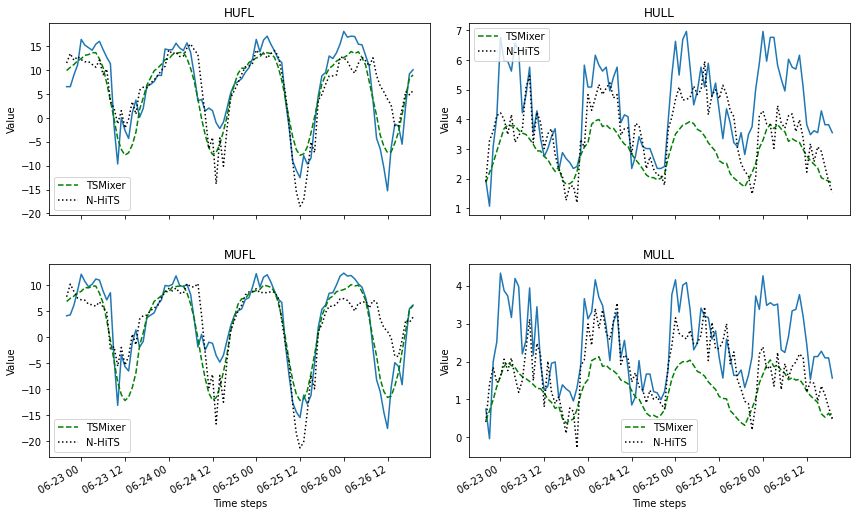

In [51]:
nhits_preds = clean_last_n_preds_df
tsmixer_preds = preds_df 

cols_to_plot = ['HUFL', 'HULL', 'MUFL', 'MULL']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    col = cols_to_plot[i]
    
    nhits_df = nhits_preds[nhits_preds['unique_id'] == col] 
    
    ax.plot(df['date'][-96:], df[col][-96:])
    ax.plot(df['date'][-96:], tsmixer_preds[col], label='TSMixer', ls='--', color='green')
    ax.plot(df['date'][-96:], nhits_df['NHITS'], label='N-HiTS', ls=':', color='black')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

In [52]:
# 使用MAE和MSE进行评估
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_actual = df.drop('date', axis=1)[-96:]

data = {'N-HiTS': 
            [mean_absolute_error(nhits_preds['y'], nhits_preds['NHITS']), 
             mean_squared_error(nhits_preds['y'], nhits_preds['NHITS'])],
       'TSMixer': 
            [mean_absolute_error(y_actual, tsmixer_preds), 
             mean_squared_error(y_actual, tsmixer_preds)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)


,N-HiTS,TSMixer
mae,1.816012,1.492569
mse,9.805936,4.660740


In [ ]:
# TSMixer 在 96 个时间步的多元预测任务上优于 N-HiTS，因为它实现了最低的 MAE 和 MSE。